# Deep Learning: Final Project

## Setup

In [1]:
!pip install torch torchvision numpy matplotlib pandas


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torchvision
import numpy as np
import torch
from torch.utils.data import DataLoader
import json
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import pandas as pd

### Download pre-trained model

In [3]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

### Setup dataset

In [4]:
!unzip -n TestDataSet.zip

Archive:  TestDataSet.zip


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=mean_norms, std=std_norms) 
])

batch_size = 128
dataset_path = "./TestDataSet"
orig_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
orig_dataloader = DataLoader(orig_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
# Load label mapping
with open(dataset_path + '/labels_list.json', "r") as f:
    label_list = json.load(f)
class_idx = [int(label.split(': ')[0]) for label in label_list]
class_label = [label.split(': ')[1] for label in label_list]

# map imagenet index to labels
imagenet_class_mapping = {idx: label for idx, label in zip(class_idx, class_label)}

# map dataset target to imagenet target
label_to_imagenet = {target: idx for target, idx in enumerate(class_idx)}

In [7]:
def denormalize(image, mean_norms=mean_norms, std_norms=std_norms):
    """denormalize image tensor using mean/std"""
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(image.device)
    return torch.clamp(image * std + mean, 0, 1)

## Task 1: Evaluate pre-trained model

In [8]:
def evaluate(model, dataloader, save_preds=False, col_name=None, filepath='pred.csv'):
    model = model.to(device)
    model.eval()

    top1_correct = 0
    top5_correct = 0
    total = 0
    preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # map targets from test dataset to imagenet predictions
            imagenet_labels = torch.tensor(
                [label_to_imagenet[int(l)] for l in labels], device=device
            )

            # get preds
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            # Top-1 accuracy
            top1_correct += (top5_preds[:, 0] == imagenet_labels).sum().item()
            preds.extend(top5_preds[:, 0].cpu().numpy())

            # Top-5 accuracy
            for i in range(images.size(0)):
                if imagenet_labels[i].item() in top5_preds[i]:
                    top5_correct += 1

            total += images.size(0)

    # Compute accuracy
    top1_acc = top1_correct / total
    top5_acc = top5_correct / total

    # save predictions in csv if needed
    if save_preds:
        if not col_name:
            raise ValueError('Expected column name')
        if os.path.isfile(filepath):
            df = pd.read_csv(filepath)
            df[col_name] = preds
        else:
            df = pd.DataFrame({col_name: preds})
        df.to_csv(filepath, index=False)

    print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc * 100:.2f}%")
    return preds

orig_preds = evaluate(pretrained_model, orig_dataloader, save_preds=True, col_name='orig')


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


## Task 2: Pixel-wise attacks

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [9]:
fgsm_output_dir = "./AdversarialTestSet1"
os.makedirs(fgsm_output_dir, exist_ok=True)

In [10]:
adv_dataloader = torch.utils.data.DataLoader(orig_dataset, batch_size=1, shuffle=False)
epsilon = 0.02 / std_norms
epsilon_tensor = torch.tensor(epsilon).view(1, 3, 1, 1).to(device)

In [11]:
# FGSM attack
def fgsm_attack(image, label, model, epsilon_tensor):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon_tensor * sign_data_grad
    min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
    max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)

    return torch.clamp(perturbed_image, min=min_vals, max=max_vals).to(dtype=torch.float32)

In [12]:
# Save images
from pathlib import Path

# Get original image file paths from the dataset
original_paths = [Path(orig_dataset.imgs[i][0]) for i in range(len(orig_dataset))]

# Attack loop
orig_images = []
fgsm_images = []

for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    # map targets from test dataset to imagenet predictions
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    fgsm_image = fgsm_attack(image.clone(), imagenet_label, pretrained_model, epsilon_tensor)
    orig_images.append(image.squeeze(0).cpu())
    fgsm_images.append(fgsm_image.squeeze(0).cpu())

    # Determine relative path inside dataset
    orig_path = original_paths[i]
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(fgsm_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(fgsm_image).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


### Get FGSM accuracy drop

In [13]:
fgsm_dataset = torchvision.datasets.ImageFolder(root=fgsm_output_dir, transform=plain_transforms)
fgsm_dataloader = DataLoader(fgsm_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
fgsm_preds = evaluate(pretrained_model, fgsm_dataloader, save_preds=True, col_name='fgsm')

Top-1 Accuracy: 6.00%
Top-5 Accuracy: 31.40%


### Verify L_inf

In [14]:
# Report L_inf statistics
def get_max_linf(orig_images, adv_images):
    # assert len(orig_dataset) == len(adv_dataset), "Datasets must have the same length"
    assert len(orig_dataset) == len(orig_images)

    max_diff = 0
    for orig_image, adv_image in zip(orig_images, adv_images):
        denorm_orig_image = denormalize(orig_image)
        denorm_adv_image = denormalize(adv_image)
        diff = torch.abs(denorm_orig_image - denorm_adv_image)
        max_diff = max(max_diff, diff.max().item())
    print(rf"Max L_inf difference: {max_diff:.5f}")

get_max_linf(orig_images, fgsm_images)

Max L_inf difference: 0.02000


### Get Successful Attack Samples

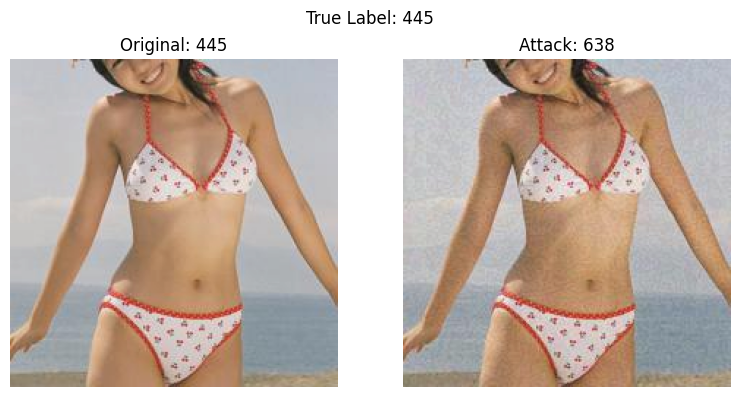

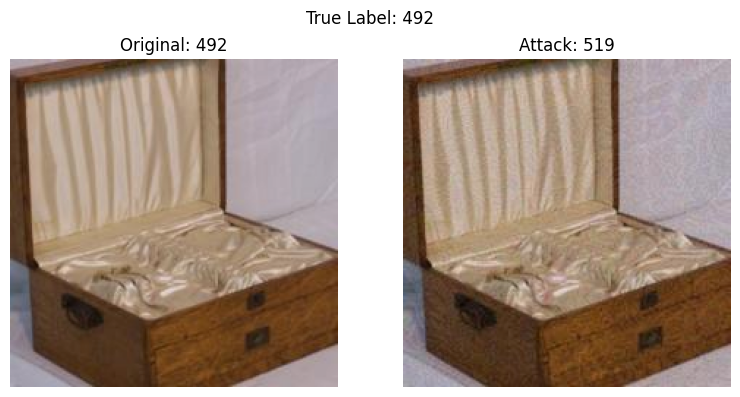

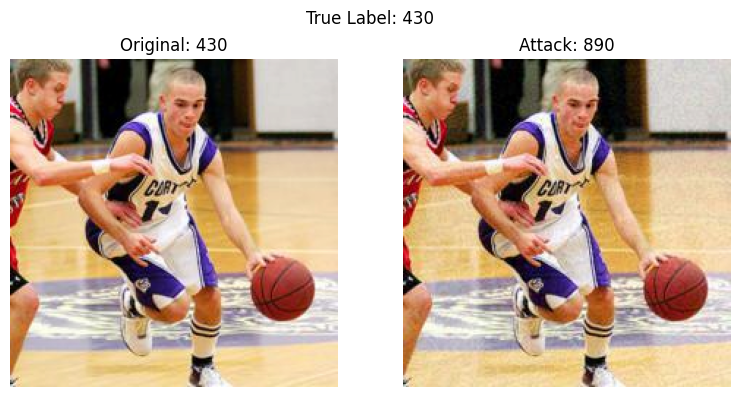

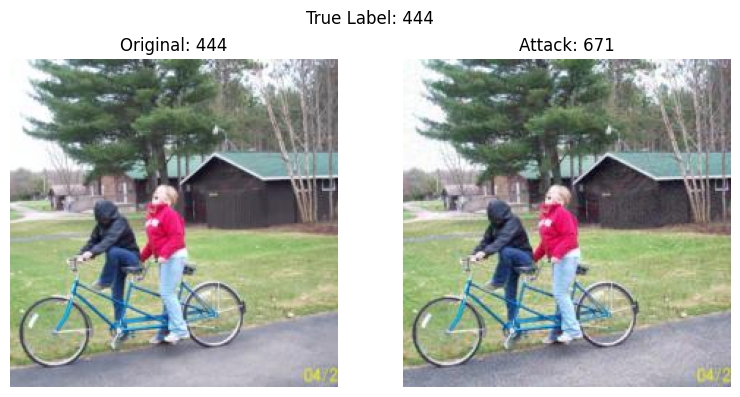

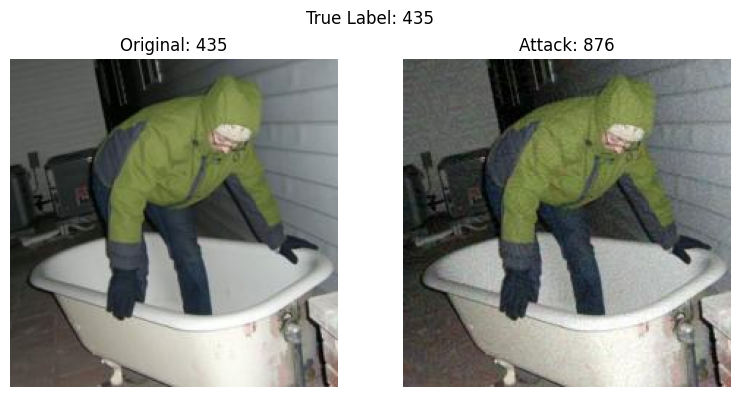

In [15]:
import random

def show_successful_attacks(indices, model, orig_dataset, adv_dataset):
    model.eval()

    for i in indices:
        # Load normalized images and label
        orig_img, label1 = orig_dataset[i]
        adv_img, _ = adv_dataset[i]
        label = label1

        # Run model
        with torch.no_grad():
            orig_pred = model(orig_img.unsqueeze(0).to(device)).argmax(dim=1).item()
            adv_pred = model(adv_img.unsqueeze(0).to(device)).argmax(dim=1).item()

        # Denormalize for visualization
        orig_vis = denormalize(orig_img.unsqueeze(0)).squeeze(0).cpu()
        adv_vis = denormalize(adv_img.unsqueeze(0)).squeeze(0).cpu()

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        fig.suptitle(f"True Label: {label_to_imagenet[label]}")
        axs[0].imshow(TF.to_pil_image(orig_vis))
        axs[0].set_title(f"Original: {orig_pred}")
        axs[1].imshow(TF.to_pil_image(adv_vis))
        axs[1].set_title(f"Attack: {adv_pred}")
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.show()

successful_attacks = []
df = pd.read_csv('pred.csv')

for idx, row in df.iterrows():
    img, label = orig_dataset[idx]
    if label_to_imagenet[label] == row['orig'] and row['orig'] != row['fgsm']:
        successful_attacks.append(idx)

# Show 5 random successful attacks
selected = random.sample(successful_attacks, min(5, len(successful_attacks)))
show_successful_attacks(selected, pretrained_model, orig_dataset, fgsm_dataset)


## Task 3: Improved Attacks

### Projected Gradient Descent

In [16]:
def pgd_attack(model, images, labels, epsilon, alpha, num_iter, mean_norms=mean_norms, std_norms=std_norms):
    """
    PGD attack under L∞ norm.

    Args:
        model: pretrained model
        images: normalized input images (B, C, H, W)
        labels: correct labels (mapped to ImageNet indices)
        epsilon: max perturbation (same shape as image or broadcastable)
        alpha: step size (same shape as epsilon)
        num_iter: number of attack steps
        mean_norms, std_norms: normalization used in preprocessing

    Returns:
        perturbed images (still normalized)
    """
    ori_images = images.clone().detach()
    perturbed = images.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        outputs = model(perturbed)
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        # Gradient sign
        grad_sign = perturbed.grad.data.sign()

        # Apply perturbation and clip to epsilon
        perturbed = perturbed + alpha * grad_sign
        delta = torch.clamp(perturbed - ori_images, min=-epsilon, max=epsilon)

        min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        perturbed = torch.clamp(ori_images + delta, min=min_vals, max=max_vals).to(torch.float32)
        perturbed = perturbed.detach().requires_grad_(True)

    return perturbed


In [17]:
def apgd_attack(model, x, y, epsilon=epsilon, steps=100, step_size=None):
    """
    Auto-PGD L_inf Attack
    Args:
        model: PyTorch model (output: logits)
        x: input images, shape [B, C, H, W]
        y: true labels, shape [B]
        eps: L∞ maximum perturbation
        steps: number of steps
        step_size: attack step size (if None, will use 2.5 * eps / steps)
    Returns:
        Adversarial examples [B, C, H, W]
    """
    model.eval()
    x_adv = x.clone().detach()
    batch_size = x.size(0)

    if step_size is None:
        step_size = 2.5 * epsilon / steps

    # Initialize with random uniform noise in L∞ ball
    x_adv += torch.empty_like(x).uniform_(-epsilon, epsilon)
    x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()

    best_loss = torch.full((batch_size,), -float('inf'), device=device)
    best_adv = x.clone()

    for i in range(steps):
        x_adv.requires_grad_(True)
        logits = model(x_adv)

        loss = F.cross_entropy(logits, y, reduction='none')

        grad = torch.autograd.grad(loss.sum(), x_adv)[0]
        x_adv = x_adv + step_size * grad.sign()
        x_adv = torch.max(torch.min(x_adv, x + epsilon), x - epsilon)
        x_adv = torch.clamp(x_adv, 0, 1).detach()

        with torch.no_grad():
            logits = model(x_adv)
            loss_eval = F.cross_entropy(logits, y, reduction='none')
            update_mask = loss_eval > best_loss
            best_loss[update_mask] = loss_eval[update_mask]
            best_adv[update_mask] = x_adv[update_mask]

    return best_adv


In [22]:
pgd_output_dir = "./AdversarialTestSet2"

alpha = epsilon / 4
alpha_tensor = torch.tensor(alpha).view(1, 3, 1, 1).to(device)

pgd_images = []

pretrained_model.eval()
for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    pgd_img = pgd_attack(pretrained_model, image, imagenet_label, epsilon_tensor, alpha_tensor, num_iter=20)
    pgd_images.append(pgd_img.cpu())

# Get original image file paths from the dataset
original_paths = [Path(orig_dataset.imgs[i][0]) for i in range(len(orig_dataset))]

# Save loop
for i, (img, orig_path) in enumerate(zip(pgd_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(pgd_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


In [23]:
pgd_dataset = torchvision.datasets.ImageFolder(root=pgd_output_dir, transform=plain_transforms)
pgd_dataloader = DataLoader(pgd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
pgd_preds = evaluate(pretrained_model, pgd_dataloader, save_preds=True, col_name='pgd')

Top-1 Accuracy: 2.00%
Top-5 Accuracy: 36.20%


In [25]:
get_max_linf(orig_images, pgd_images)

Max L_inf difference: 0.02000


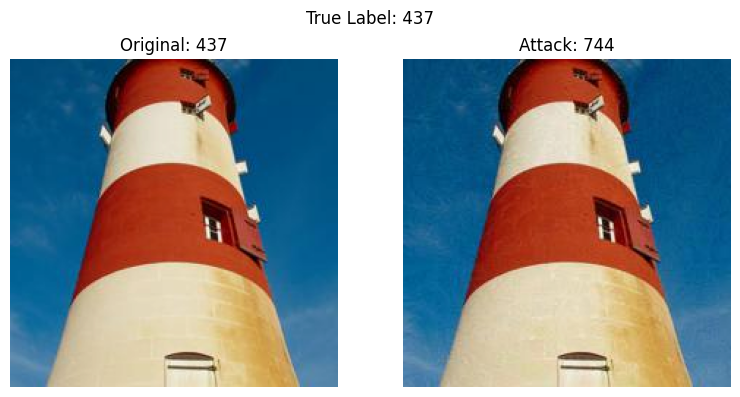

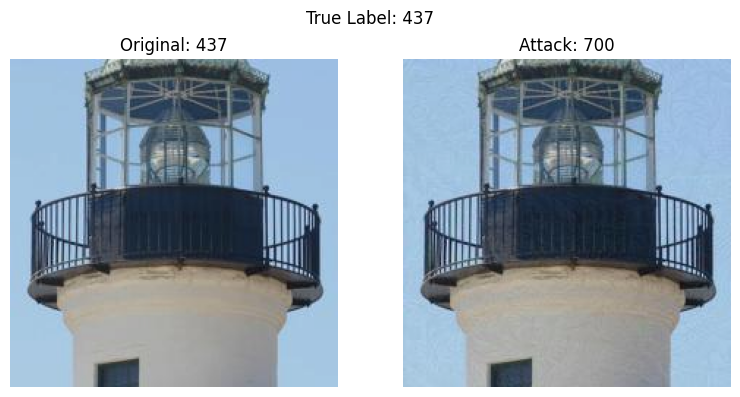

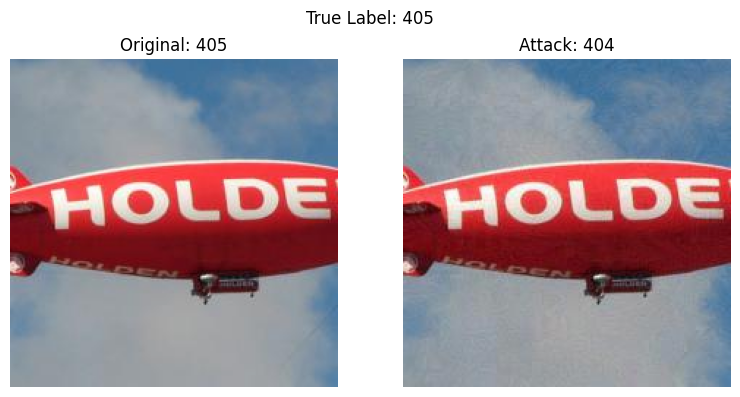

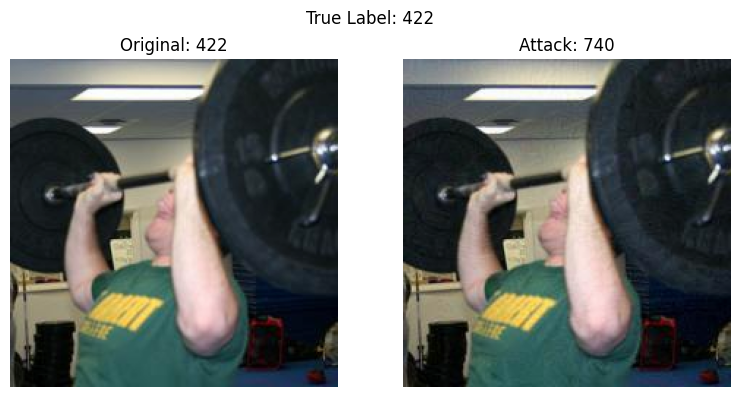

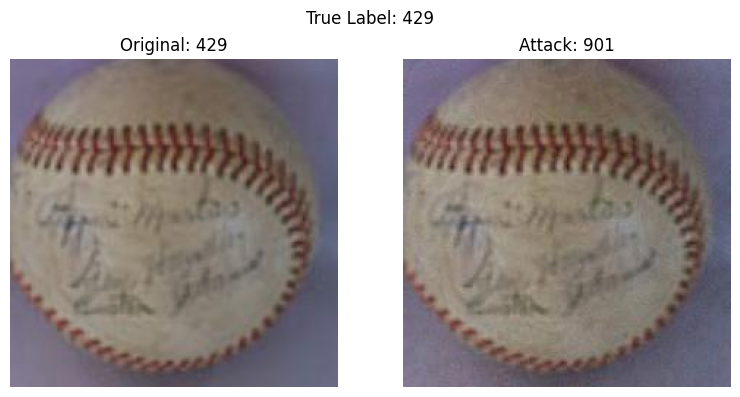

In [26]:
successful_attacks = []
df = pd.read_csv('pred.csv')

for idx, row in df.iterrows():
    img, label = orig_dataset[idx]
    if label_to_imagenet[label] == row['orig'] and \
       row['orig'] == row['fgsm'] and \
       row['fgsm'] != row['pgd']:
        successful_attacks.append(idx)

# Show 5 random successful attacks
selected = random.sample(successful_attacks, min(5, len(successful_attacks)))
show_successful_attacks(selected, pretrained_model, orig_dataset, pgd_dataset)

## Task 4: Patch Attacks


## Task 5: Transferring Attacks

In [27]:
new_model = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1')

dataloaders = {
    'original': orig_dataloader,
    'fgsm': fgsm_dataloader,
    'pgd': pgd_dataloader
}

for name, dataloader in dataloaders.items():
    print(f'Evaluating {name} dataset')
    evaluate(new_model, dataloader)
    print()


Evaluating original dataset
Top-1 Accuracy: 85.20%
Top-5 Accuracy: 98.40%

Evaluating fgsm dataset
Top-1 Accuracy: 69.80%
Top-5 Accuracy: 92.00%

Evaluating pgd dataset
Top-1 Accuracy: 77.20%
Top-5 Accuracy: 95.20%

